Preprocess archive.zip

In [ ]:
!python3 preprocess.py

Import libraries

In [1]:
import pymongo
import json
import os
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np


Connect to MongoDB

In [2]:
client = pymongo.MongoClient("localhost", 27017)

Create database and collections

In [3]:
db = client["my_db"]
collection_cat = db['youtube_categories']
collection_vids = db['videos_data']

Insert json files to collections

In [4]:
# Iterate through the json files in the "data" directory
for filename in os.listdir("data/"):
    print(f'Inserting {filename}...')
    filename = 'data/' + filename
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'category' in filename:

        collection_cat.insert_many(data["items"])
        
    else:
        # Insert the json documents into the collection
        
        collection_vids.insert_many(data)

print("Done.")

Inserting RU_youtube_trending_data.json...
Inserting GB_youtube_trending_data.json...
Inserting US_youtube_trending_data.json...
Inserting FR_youtube_trending_data.json...
Inserting CA_youtube_trending_data.json...
Inserting MX_youtube_trending_data.json...
Inserting FR_category_id.json...
Inserting JP_youtube_trending_data.json...
Inserting JP_category_id.json...
Inserting IN_category_id.json...
Inserting BR_category_id.json...
Inserting BR_youtube_trending_data.json...
Inserting IN_youtube_trending_data.json...
Inserting US_category_id.json...
Inserting DE_youtube_trending_data.json...
Inserting KR_category_id.json...
Inserting GB_category_id.json...
Inserting KR_youtube_trending_data.json...
Inserting RU_category_id.json...
Inserting DE_category_id.json...
Inserting CA_category_id.json...
Inserting MX_category_id.json...
Done.


### Task 1: Analysis of the channel "Saturday Night Live". [GB]

In [5]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'channelTitle': 'Saturday Night Live'
        }
    }, {
        '$sort': {
            'trending_date': -1
        }
    }, {
        '$group': {
            '_id': '$title', 
            'likes': {
                '$first': '$likes'
            }, 
            'dislikes': {
                '$first': '$dislikes'
            }, 
            'views': {
                '$first': '$view_count'
            }, 
            'publishedAt': {
                '$first': '$publishedAt'
            }
        }
    }, {
        '$sort': {
            'publishedAt': 1
        }
    }, {
        '$project': {
            '_id': 1, 
            'likes': 1, 
            'dislikes': 1, 
            'views': 1, 
            'publishedAt': {
                '$dateToString': {
                    'format': '%Y-%m-%d', 
                    'date': {
                        '$convert': {
                            'input': '$publishedAt', 
                            'to': 'date'
                        }
                    }
                }
            }
        }
    }
])

views = []
publishedAt = []
for item in result:
    publishedAt.append(item['publishedAt'])
    views.append(item['views'])

### Task 1: Visualization

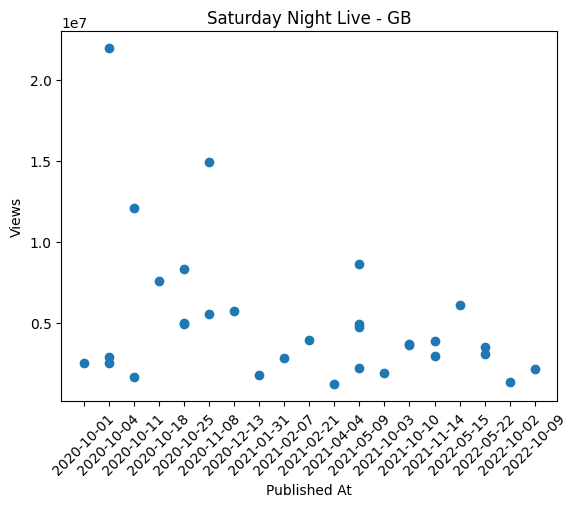

In [6]:


plt.scatter(publishedAt, views)
plt.xlabel('Published At')
plt.ylabel('Views')
plt.xticks(rotation=45)
plt.title("Saturday Night Live - GB")
plt.show()


### Task 2: How many tags are used per video? [GB]

In [7]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'tags': {
                '$nin': [
                    '[None]'
                ]
            }, 
            'view_count': {
                '$gt': 0
            }
        }
    }, {
        '$sort': {
            'trending_date': -1
        }
    }, {
        '$group': {
            '_id': '$title', 
            'avg_num_tags': {
                '$avg': {
                    '$size': '$tags'
                }
            }, 
            'views': {
                '$first': '$view_count'
            }, 
            'video_id': {
                '$first': '$video_id'
            }
        }
    }, {
        '$sort': {
            'views': -1
        }
    }, {
        '$project': {
            '_id': 0, 
            'avg_num_tags': 1, 
            'video_id': 1, 
            'views': 1
        }
    }
])

views = []
avg_num_tags = []
for item in result:
    avg_num_tags.append(item['avg_num_tags'])
    views.append(item['views'])

### Task 2: Visualize

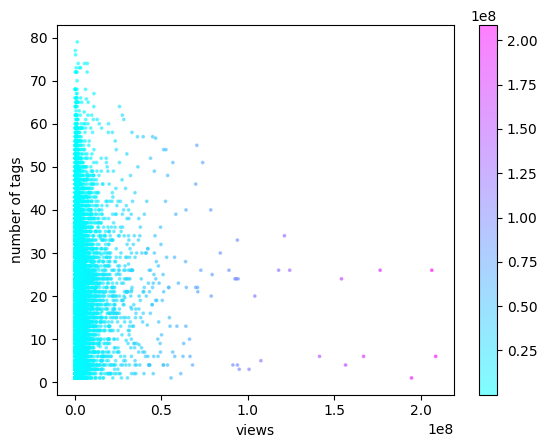

In [8]:
plt.scatter(views, avg_num_tags, s=3, alpha=0.5, c=views, cmap='cool')
plt.colorbar()
plt.xlabel('views')
plt.ylabel('average number of tags')
plt.show()

### Task 3:

In [11]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'tags': {
                '$nin': [
                    '[None]'
                ]
            }
        }
    }, {
        '$group': {
            '_id': {
                'video_id': '$video_id', 
                'country': '$country'
            }, 
            'num_tags': {
                '$push': '$tags'
            }, 
            'view_count': {
                '$max': '$view_count'
            }
        }
    }, {
        '$unwind': {
            'path': '$num_tags'
        }
    }, {
        '$unwind': {
            'path': '$num_tags'
        }
    }, {
        '$group': {
            '_id': '$_id', 
            'num_tags': {
                '$addToSet': '$num_tags'
            }, 
            'view_count': {
                '$first': '$view_count'
            }
        }
    }, {
        '$group': {
            '_id': '$_id.country', 
            'avg_tags_per_video': {
                '$avg': {
                    '$size': '$num_tags'
                }
            }, 
            'avg_views_per_video': {
                '$avg': '$view_count'
            }
        }
    }, {
        '$project': {
            'avg_tags_per_video': {
                '$round': [
                    '$avg_tags_per_video', 2
                ]
            }, 
            'avg_views_per_video': {
                '$round': [
                    '$avg_views_per_video', 2
                ]
            }
        }
    }
])

country = []
avg_tags_per_video = []
avg_views_per_video = []

for item in result:
    country.append(item['_id'])
    avg_tags_per_video.append(item['avg_tags_per_video'])
    avg_views_per_video.append(item['avg_views_per_video'])

### Task 3: Visualization

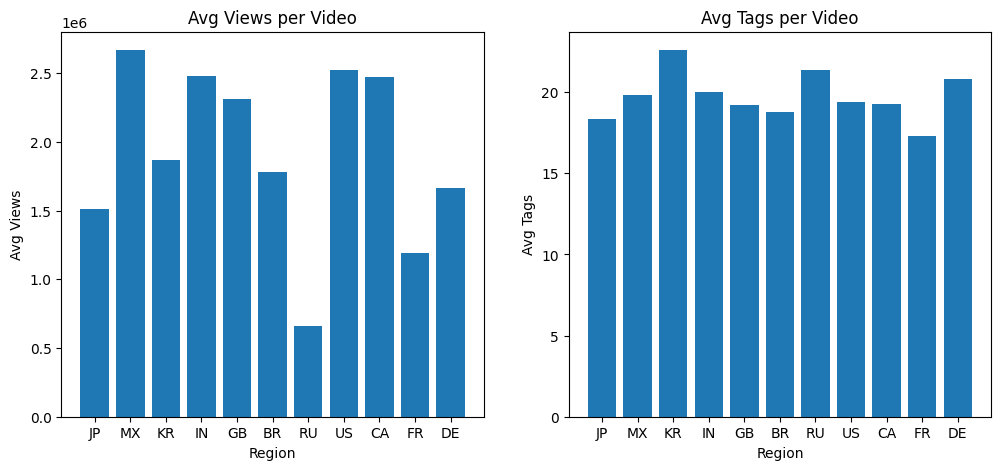

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1.bar(country, avg_views_per_video)
ax1.set_title('Avg Views per Video')
ax1.set_xlabel('Region')
ax1.set_ylabel('Avg Views')

# Plot the avg tags data on ax2
ax2.bar(country, avg_tags_per_video)
ax2.set_title('Avg Tags per Video')
ax2.set_xlabel('Region')
ax2.set_ylabel('Avg Tags')

# Show the plot
plt.show()

### Task 4:

In [22]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': {
                '$in': [
                    'US', 'GB'
                ]
            }
        }
    }, {
        '$unwind': {
            'path': '$tags'
        }
    }, {
        '$group': {
            '_id': '$tags', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }, {
        '$limit': 30
    }, {
        '$project': {
            'count': 1, 
            '_id': 1
        }
    }
])

counts = []
tags = []

for item in result:
    counts.append(item['count'])
    tags.append(item['_id'])

### Task 4: Visualize

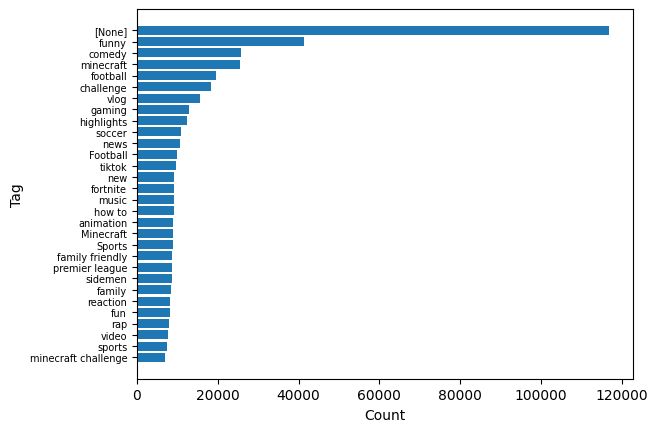

In [25]:
plt.barh(tags, counts)
plt.xlabel('Count')
plt.ylabel('Tag')
ax = plt.gca()
ax.invert_yaxis() # to invert the y axis 
ax.yaxis.set_tick_params(labelsize=7)
plt.show()

### Task 5:

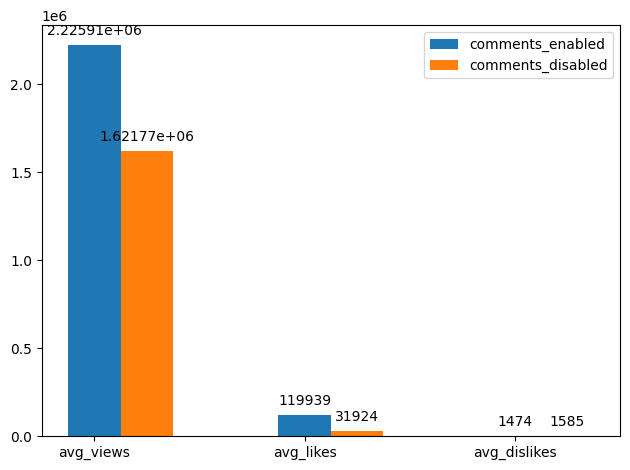

In [17]:
result1 = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'comments_disabled': True
        }
    }, {
        '$group': {
            '_id': None, 
            'avg_views': {
                '$avg': '$view_count'
            }, 
            'avg_likes': {
                '$avg': '$likes'
            }, 
            'avg_dislikes': {
                '$avg': '$dislikes'
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'avg_views': {
                '$trunc': [
                    '$avg_views', 2
                ]
            }, 
            'avg_likes': {
                '$trunc': [
                    '$avg_likes', 2
                ]
            }, 
            'avg_dislikes': {
                '$trunc': [
                    '$avg_dislikes', 2
                ]
            }
        }
    }
])


result2 = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'comments_disabled': False
        }
    }, {
        '$group': {
            '_id': None, 
            'avg_views': {
                '$avg': '$view_count'
            }, 
            'avg_likes': {
                '$avg': '$likes'
            }, 
            'avg_dislikes': {
                '$avg': '$dislikes'
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'avg_views': {
                '$trunc': [
                    '$avg_views', 2
                ]
            }, 
            'avg_likes': {
                '$trunc': [
                    '$avg_likes', 2
                ]
            }, 
            'avg_dislikes': {
                '$trunc': [
                    '$avg_dislikes', 2
                ]
            }
        }
    }
])



comments_disabled = []
comments_enabled = []

for item in result1:
    comments_disabled.append(round(item['avg_views']))
    comments_disabled.append(round(item['avg_likes']))
    comments_disabled.append(round(item['avg_dislikes']))

for item in result2:
    comments_enabled.append(round(item['avg_views']))
    comments_enabled.append(round(item['avg_likes']))
    comments_enabled.append(round(item['avg_dislikes']))


labels = ['avg_views', 'avg_likes', 'avg_dislikes']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x + 0.00, comments_enabled, width, label='comments_enabled')
rects2 = ax.bar(x + 0.25, comments_disabled, width, label='comments_disabled')


ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)

fig.tight_layout()

plt.show()

### Task 6:

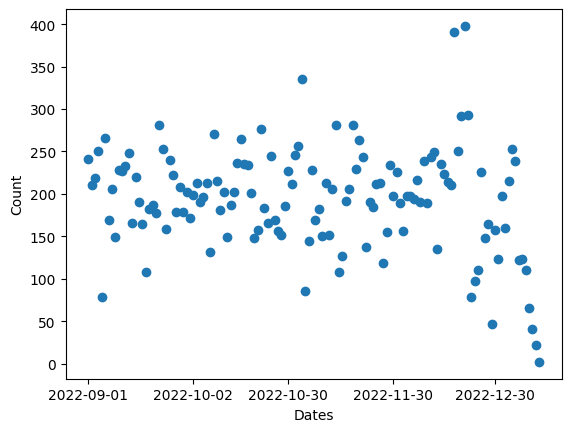

In [18]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB'
        }
    }, {
        '$project': {
            'date': {
                '$dateToString': {
                    'format': '%Y-%m-%d', 
                    'date': {
                        '$convert': {
                            'input': '$publishedAt', 
                            'to': 'date'
                        }
                    }
                }
            }
        }
    }, {
        '$match': {
            'date': {
                '$gte': '2022-09-01'
            }
        }
    }, {
        '$group': {
            '_id': '$date', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }, {
        '$project': {
            'date': '$_id', 
            'count': 1, 
            '_id': 0
        }
    }
])

# 'result' is an iterator object?
x_values = []
y_values = []
for item in result:
    x_values.append(item['date'])
    y_values.append(item['count'])

plt.scatter(x_values, y_values)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Dates')
plt.ylabel('Count')
plt.show()